In [1]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  8
GPU Name:  NVIDIA A100-SXM4-40GB
Using device: cuda


Dataset Setup

In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import numpy as np

class RetinalDataset(Dataset):
    def __init__(self, root_dir, target_disease, transform=None):
        self.root_dir = root_dir
        self.target_disease = target_disease
        self.transform = transform
        self.images = []
        self.labels = []

        for disease in os.listdir(root_dir):
            disease_path = os.path.join(root_dir, disease)
            label = 1 if disease == self.target_disease else 0
            for img_file in os.listdir(disease_path):
                img_path = os.path.join(disease_path, img_file)
                self.images.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Failed to load image: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long)

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Set paths
base_path = "/home/srmist19/Retinal_Fundus_Images/Retinal Fundus Images"
train_path = os.path.join(base_path, "train")
val_path = os.path.join(base_path, "val")
test_path = os.path.join(base_path, "test")

# Verify paths
for path in [train_path, val_path, test_path]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"{path} not found")

# Choose target disease
disease_folders = sorted(os.listdir(train_path))
target_disease = "8.Glaucoma"
print(f"Target disease: {target_disease}")
print(f"All diseases: {disease_folders}")

# Create datasets
train_dataset = RetinalDataset(train_path, target_disease, transform=transform)
val_dataset = RetinalDataset(val_path, target_disease, transform=transform)
test_dataset = RetinalDataset(test_path, target_disease, transform=transform)

# Check label distribution
train_labels = [label.item() for _, label in train_dataset]
val_labels = [label.item() for _, label in val_dataset]
test_labels = [label.item() for _, label in test_dataset]
print(f"Train: {len(train_dataset)} samples, Positive (1): {sum(train_labels)}, Negative (0): {len(train_labels) - sum(train_labels)}")
print(f"Val: {len(val_dataset)} samples, Positive (1): {sum(val_labels)}, Negative (0): {len(val_labels) - sum(val_labels)}")
print(f"Test: {len(test_dataset)} samples, Positive (1): {sum(test_labels)}, Negative (0): {len(test_labels) - sum(test_labels)}")

# DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Verify a batch
for images, labels in train_loader:
    print("Batch shape:", images.shape)
    print("Labels in batch:", labels.tolist())
    break

Target disease: 8.Glaucoma
All diseases: ['1.Dry AMD', '2.Wet AMD', '3.Mild DR', '4.Moderate DR', '5.Severe DR', '6.Proliferate DR', '7.Cataract', '8.Glaucoma', '9.Normal Fundus']
Train: 17715 samples, Positive (1): 1678, Negative (0): 16037
Val: 382 samples, Positive (1): 44, Negative (0): 338
Test: 1040 samples, Positive (1): 156, Negative (0): 884
Batch shape: torch.Size([16, 3, 224, 224])
Labels in batch: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]


Model Definition

In [3]:
import torch.nn as nn
from torchvision import models
import timm  # For EfficientNet models

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Function to modify final layer
def modify_model(model, num_classes=2):
    if isinstance(model, models.VGG):
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif isinstance(model, models.ResNet):
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif isinstance(model, models.DenseNet):
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif isinstance(model, models.Inception3):
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif 'efficientnet' in str(type(model)).lower():
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model

# Define models with fallback for missing pretrained weights
models_dict = {}
try:
    models_dict["VGG16"] = modify_model(models.vgg16(pretrained=True))
    models_dict["VGG19"] = modify_model(models.vgg19(pretrained=True))
    models_dict["ResNet50"] = modify_model(models.resnet50(pretrained=True))
    models_dict["ResNet101"] = modify_model(models.resnet101(pretrained=True))
    models_dict["DenseNet121"] = modify_model(models.densenet121(pretrained=True))
    models_dict["DenseNet169"] = modify_model(models.densenet169(pretrained=True))
    models_dict["InceptionV3"] = modify_model(models.inception_v3(pretrained=True, aux_logits=True))
    try:
        models_dict["EfficientNetB6"] = modify_model(timm.create_model('efficientnet_b6', pretrained=True))
    except RuntimeError as e:
        print(f"Warning: {e}. Falling back to random init for EfficientNetB6.")
        models_dict["EfficientNetB6"] = modify_model(timm.create_model('efficientnet_b6', pretrained=False))
    try:
        models_dict["EfficientNetB7"] = modify_model(timm.create_model('efficientnet_b7', pretrained=True))
    except RuntimeError as e:
        print(f"Warning: {e}. Falling back to random init for EfficientNetB7.")
        models_dict["EfficientNetB7"] = modify_model(timm.create_model('efficientnet_b7', pretrained=False))
except Exception as e:
    print(f"Error loading models: {e}")

# Move models to GPU
for name, model in models_dict.items():
    models_dict[name] = model.to(device)
    print(f"{name} loaded on {device}")

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warni

VGG16 loaded on cuda
VGG19 loaded on cuda
ResNet50 loaded on cuda
ResNet101 loaded on cuda
DenseNet121 loaded on cuda
DenseNet169 loaded on cuda
InceptionV3 loaded on cuda
EfficientNetB6 loaded on cuda
EfficientNetB7 loaded on cuda


Training loop

In [4]:
import time
import torchvision.transforms.functional as TF

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        start_time = time.time()

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Resize for InceptionV3 only
            if isinstance(model, models.Inception3):
                images = TF.resize(images, (299, 299))  # Resize to 299x299 for InceptionV3

            optimizer.zero_grad()
            if isinstance(model, models.Inception3):
                outputs, _ = model(images)  # Handle aux_logits for InceptionV3
            else:
                outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i % 10 == 0:
                print(f"Epoch {epoch+1}, Batch {i}: Loss {loss.item():.4f}")

        train_loss = running_loss / len(train_dataset)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Time: {epoch_time:.2f}s")

    return train_losses, train_accuracies

# Train all models
results = {}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pos_weight = torch.tensor([16037 / 1678], device=device)  # ≈ 9.56
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, pos_weight], device=device))
num_epochs = 10

for name, model in models_dict.items():
    print(f"\nTraining {name}...")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Adjusted lr
    train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, num_epochs)
    results[name] = {"train_losses": train_losses, "train_accuracies": train_accuracies}


Training VGG16...
Epoch 1, Batch 0: Loss 0.4404
Epoch 1, Batch 10: Loss 1.0595
Epoch 1, Batch 20: Loss 0.3964
Epoch 1, Batch 30: Loss 0.7265
Epoch 1, Batch 40: Loss 0.6822
Epoch 1, Batch 50: Loss 0.6804
Epoch 1, Batch 60: Loss 0.6360
Epoch 1, Batch 70: Loss 0.6791
Epoch 1, Batch 80: Loss 0.9161
Epoch 1, Batch 90: Loss 0.5898
Epoch 1, Batch 100: Loss 1.0406
Epoch 1, Batch 110: Loss 0.7485
Epoch 1, Batch 120: Loss 0.6701
Epoch 1, Batch 130: Loss 0.7543
Epoch 1, Batch 140: Loss 0.7460
Epoch 1, Batch 150: Loss 0.7266
Epoch 1, Batch 160: Loss 0.6718
Epoch 1, Batch 170: Loss 0.8428
Epoch 1, Batch 180: Loss 0.6844
Epoch 1, Batch 190: Loss 0.8354
Epoch 1, Batch 200: Loss 0.7036
Epoch 1, Batch 210: Loss 1.4649
Epoch 1, Batch 220: Loss 0.8492
Epoch 1, Batch 230: Loss 0.6715
Epoch 1, Batch 240: Loss 0.7110
Epoch 1, Batch 250: Loss 0.6718
Epoch 1, Batch 260: Loss 0.6654
Epoch 1, Batch 270: Loss 0.6921
Epoch 1, Batch 280: Loss 0.7684
Epoch 1, Batch 290: Loss 0.7223
Epoch 1, Batch 300: Loss 0.6757


Evaluation

In [5]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve
import torchvision.transforms.functional as TF

def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            if isinstance(model, models.Inception3):
                images = TF.resize(images, (299, 299))  # Resize for InceptionV3
            outputs = model(images)  # No unpacking; handle output directly
            if isinstance(model, models.Inception3) and model.training:
                outputs = outputs[0]  # If in training mode, take main output from tuple

            _, predicted = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)[:, 1]

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = 100 * correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    auc_roc = roc_auc_score(all_labels, all_probs)
    fpr, tpr, _ = roc_curve(all_labels, all_probs)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc_roc": auc_roc,
        "fpr": fpr,
        "tpr": tpr
    }

metrics = {}
for name, model in models_dict.items():
    print(f"\nEvaluating {name}...")
    metrics[name] = evaluate_model(model, test_loader)

for name, m in metrics.items():
    print(f"\n{name}:")
    print(f"Accuracy: {m['accuracy']:.2f}%")
    print(f"Precision: {m['precision']:.4f}")
    print(f"Recall: {m['recall']:.4f}")
    print(f"F1-Score: {m['f1']:.4f}")
    print(f"AUC-ROC: {m['auc_roc']:.4f}")


Evaluating VGG16...

Evaluating VGG19...


/home/srmist19/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Evaluating ResNet50...


/home/srmist19/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Evaluating ResNet101...

Evaluating DenseNet121...

Evaluating DenseNet169...

Evaluating InceptionV3...

Evaluating EfficientNetB6...

Evaluating EfficientNetB7...

VGG16:
Accuracy: 85.00%
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
AUC-ROC: 0.5000

VGG19:
Accuracy: 85.00%
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
AUC-ROC: 0.6188

ResNet50:
Accuracy: 97.79%
Precision: 0.9130
Recall: 0.9423
F1-Score: 0.9274
AUC-ROC: 0.9914

ResNet101:
Accuracy: 95.96%
Precision: 0.8276
Recall: 0.9231
F1-Score: 0.8727
AUC-ROC: 0.9922

DenseNet121:
Accuracy: 97.40%
Precision: 0.8772
Recall: 0.9615
F1-Score: 0.9174
AUC-ROC: 0.9967

DenseNet169:
Accuracy: 96.25%
Precision: 0.8503
Recall: 0.9103
F1-Score: 0.8793
AUC-ROC: 0.9887

InceptionV3:
Accuracy: 97.88%
Precision: 0.9408
Recall: 0.9167
F1-Score: 0.9286
AUC-ROC: 0.9937

EfficientNetB6:
Accuracy: 94.23%
Precision: 0.7697
Recall: 0.8782
F1-Score: 0.8204
AUC-ROC: 0.9787

EfficientNetB7:
Accuracy: 93.37%
Precision: 0.9307
Recall: 0.6026
F1-Sc

Plotting

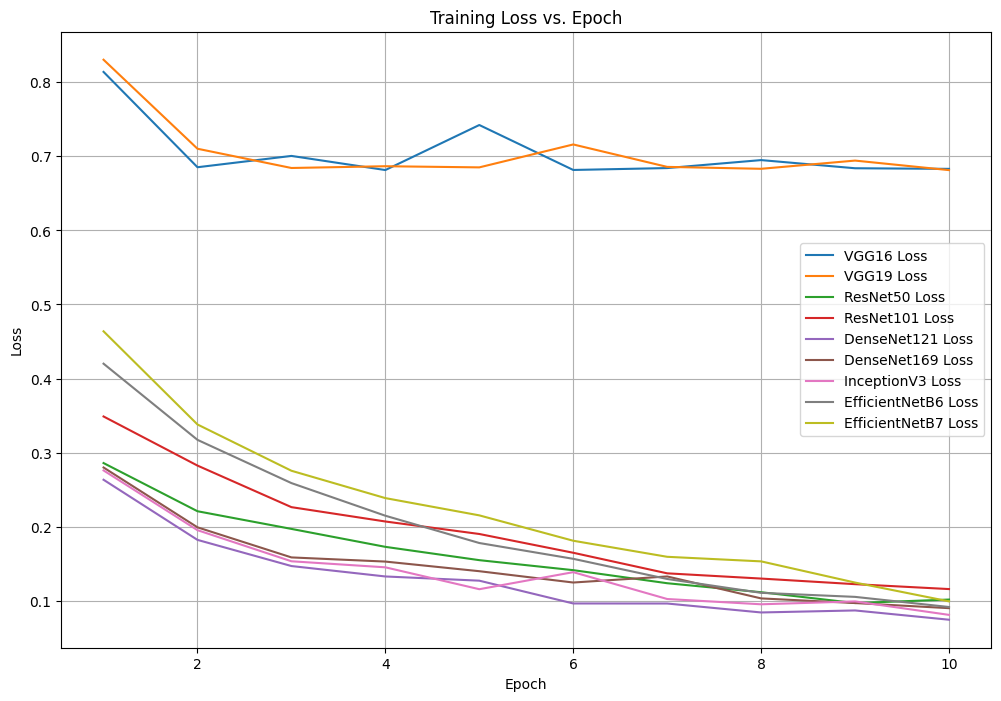

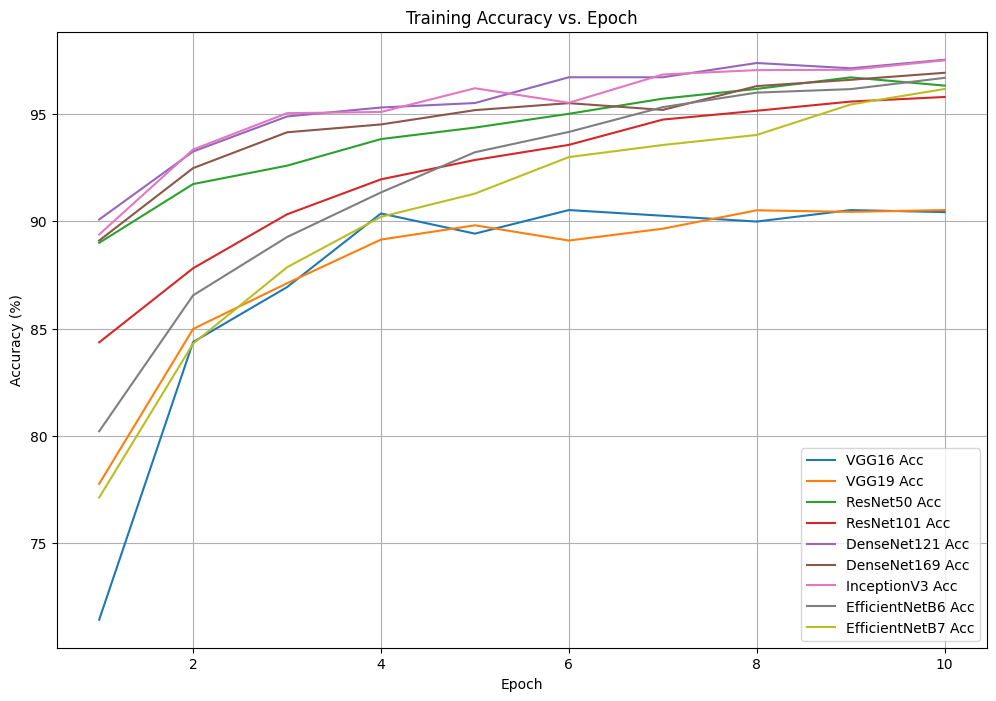

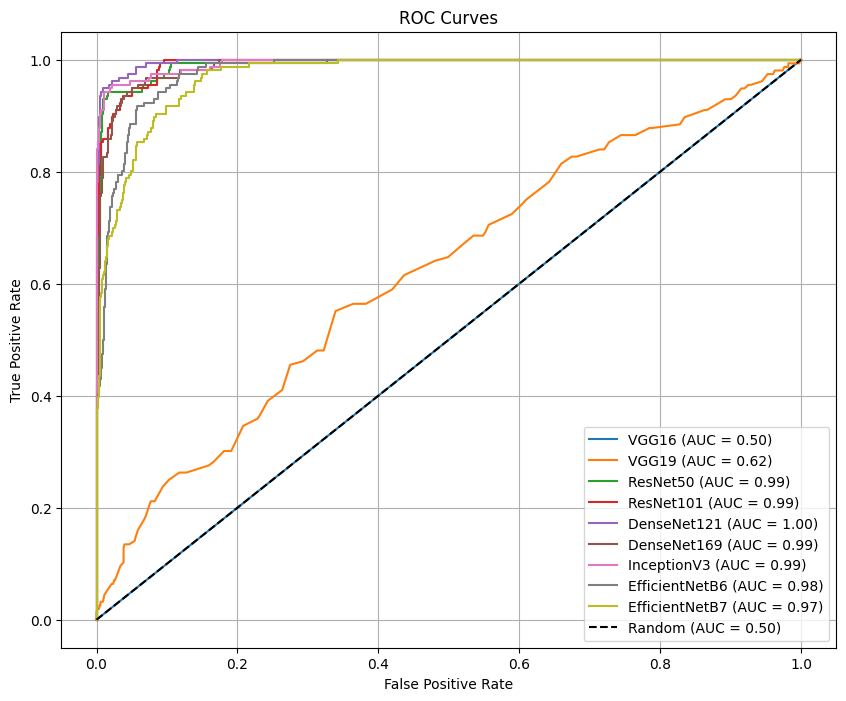

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for name, res in results.items():
    plt.plot(range(1, num_epochs+1), res['train_losses'], label=f"{name} Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs. Epoch")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 8))
for name, res in results.items():
    plt.plot(range(1, num_epochs+1), res['train_accuracies'], label=f"{name} Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy vs. Epoch")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 8))
for name, m in metrics.items():
    plt.plot(m['fpr'], m['tpr'], label=f"{name} (AUC = {m['auc_roc']:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC = 0.50)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid()
plt.show()